# Topic 42: Transfer Learning and Tuning Neural Networks

1. Using GridSearch/Talos for finding optimal parameter combinations 
2. Saving your neural network to disk
4. Transfer Learning

## 1. Tuning hyperparameters with Keras Models

There are a couple ways to go about testing combinations of parameters, GridSearch style:
* **Using SKlearn GridSearch**: https://chrisalbon.com/deep_learning/keras/tuning_neural_network_hyperparameters/
    * This involves creating a model object such that scikit-learn's existing GridSearch functions work with your neural net.
* **Using KerasTuner**: https://www.tensorflow.org/tutorials/keras/keras_tuner
* **Using Talos**: https://autonomio.github.io/talos/#/Scan
    * This library lets you tune without having to create the model object, and also can automatically output your parameter combination scores into a csv file

In [28]:
# !pip install talos
import talos

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.callbacks import EarlyStopping



## Data:
Let's return to our Seattle Housing data from the last study group.

We are going to split the testing set into a validation and a holdout set.

In [29]:
train = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/011121-pt-ds/main/phase_4/advanced-neural-networks/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/011121-pt-ds/main/phase_4/advanced-neural-networks/test.csv')
split = int(len(test)*.5)
val = test.iloc[:split, :]
holdout = test.iloc[split:, :]

X_train, y_train = (train.drop('price', axis=1), train['price'])
X_val, y_val = (val.drop('price', axis=1), val['price'])
X_holdout, y_holdout = (holdout.drop('price', axis=1), holdout['price'])

display(train)
train.info()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,lat,...,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,price
0,-0.402511,-0.479166,-1.044407,-0.266958,-0.917244,0.907485,-0.563361,-1.106775,-1.875431,0.781814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,445000.0
1,-0.402511,-0.479166,-0.547215,-0.204171,-0.917244,-0.629858,-0.563361,-0.254565,0.574854,-2.019417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279900.0
2,-0.402511,-0.801723,-0.320235,-0.182459,-0.917244,-0.629858,-0.563361,-0.002503,-0.616257,0.567721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,865000.0
3,-0.402511,0.488506,-0.104064,-0.267341,0.937512,-0.629858,0.288544,0.237556,1.119362,0.226758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,560200.0
4,0.669418,0.488506,-0.071639,-0.213373,0.937512,-0.629858,-0.563361,0.273564,1.051299,-2.020859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,-1.474441,-1.446837,-1.238961,-0.178290,-0.917244,0.907485,-1.415265,-1.022754,-1.875431,1.057900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329000.0
16193,-0.402511,0.488506,0.425554,0.544071,0.010134,0.907485,0.288544,0.825700,0.098410,-1.150790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663000.0
16194,-0.402511,-0.479166,-0.817428,-0.060432,-0.917244,-0.629858,-0.563361,-0.554639,0.404696,-0.862449,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,265000.0
16195,-0.402511,-0.479166,-0.098660,0.077172,0.937512,-0.629858,-0.563361,0.243557,-0.480130,-1.059963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,271500.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16197 entries, 0 to 16196
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       16197 non-null  float64
 1   bathrooms      16197 non-null  float64
 2   sqft_living    16197 non-null  float64
 3   sqft_lot       16197 non-null  float64
 4   floors         16197 non-null  float64
 5   condition      16197 non-null  float64
 6   grade          16197 non-null  float64
 7   sqft_above     16197 non-null  float64
 8   yr_built       16197 non-null  float64
 9   lat            16197 non-null  float64
 10  long           16197 non-null  float64
 11  sqft_living15  16197 non-null  float64
 12  sqft_lot15     16197 non-null  float64
 13  view           16197 non-null  float64
 14  sqft_basement  16197 non-null  float64
 15  yr_renovated   16197 non-null  float64
 16  waterfront     16197 non-null  float64
 17  zipcode_98001  16197 non-null  float64
 18  zipcod

# Define a Function to Create a Model

To work with Talos, we create a specially formed function that returns our model and the model training history.

The function must take: `X_train, y_train, X_test, y_test, params` in that order.  Params is a dictionary of parameters.  Keys should be a name for the hyperparameter.  It is arbitrary, but should be something descriptive.  The values are the range of values that hyperparameter could take.

Talos will pass only one of the possible values for each hyperparameter to the function on each experiment in the `params` dictionary that the function expects.

We then set the hyperparameters of the model generated in the function to be the value we want to try from the params dictionary.

Another note: we can adjust the depth of the model by adding layers in a loop, a series of loops, or even nested loops.

In [30]:
def dense_network(x_train, y_train, x_test, y_test, params):

    #we build the model like we would normally do it
    model = Sequential()
    
    #input layer
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    # hidden layers
    for layer in range(params['dense_layers']):
        model.add(Dense(params['nodes'], activation=params['activation']))
        model.add(layers.Dropout(params['dropout']))
    
    # output layer
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=params['optimizer'], metrics=['mae', 'mse'])
    
    #callback to prevent over-training
    earlystopping = EarlyStopping(monitor='val_loss', patience=2)
    
    out = model.fit(x_train, y_train, 
                   validation_data=(x_test, y_test),
                   batch_size=50,
                   epochs=10,
                   verbose=0,
                   callbacks = [earlystopping])

    return out, model

## Parameters:

Define a dictionary of possible parameter values.  Remember that more parameters quickly multiply the number of models Talos will compare.  It's okay to do a series of experiments based on the results of your previous ones, rather than on big gridsearch.

Alternatively you can use [Probabalistic Reduction](https://autonomio.github.io/talos/#/Probabilistic_Reduction) to instruct Scan to keep hyperparameter values that have shown to be 

In [31]:
params = {'dropout': [0.2, 0.5], 
          'optimizer': ['adam', 'sgd'], 
          'activation': ['relu', 'tanh'], 
          'dense_layers': [5,10],
          'nodes': [100,200]}

`talos.Scan()` instantiates a new scan object by conducting all of the experiments defined in `params` using the model defined in the `model=` argument and the data passed.

your scan object (named `results` below) will contain the record of your experiments, including all of the fitted models.  It also saves records to disk under the folder defined in `experiment_name=`.



In [32]:
results = talos.Scan(X_train, y_train, 
                     x_val=X_val,
                     y_val=y_val,
                     params=params, 
                     model=dense_network,
                     experiment_name='grid',
                     minimize_loss=True)


100%|██████████| 32/32 [03:42<00:00,  6.97s/it]


# Experimental Record

The record of all experiments is stored in a dataframe in the `.data` attribute.  

The scan object will keep a record of scores according to the metrics defined when the model was compiled.  You can use these metrics to order the data frame.

In [33]:
results.data.sort_values(by='val_mae', ascending=True)

,start,end,duration,round_epochs,loss,mae,mse,val_loss,val_mae,val_mse,activation,dense_layers,dropout,nodes,optimizer
2,08/03/21-152448,08/03/21-152458,9.823584,10,2.144835e+10,90865.343750,2.144835e+10,1.389579e+10,75770.218750,1.389579e+10,relu,5,0.2,200,adam
0,08/03/21-152439,08/03/21-152445,6.439806,10,2.677377e+10,100079.570312,2.677377e+10,1.526509e+10,78941.773438,1.526509e+10,relu,5,0.2,100,adam
8,08/03/21-152520,08/03/21-152529,9.569853,10,3.657275e+10,120794.320312,3.657274e+10,1.645498e+10,80395.109375,1.645498e+10,relu,10,0.2,100,adam
6,08/03/21-152509,08/03/21-152517,8.088457,8,3.464387e+10,117413.835938,3.464387e+10,1.621678e+10,82495.007812,1.621678e+10,relu,5,0.5,200,adam
4,08/03/21-152501,08/03/21-152507,6.242362,10,4.506420e+10,135867.921875,4.506420e+10,1.726049e+10,83724.015625,1.726049e+10,relu,5,0.5,100,adam
10,08/03/21-152532,08/03/21-152547,15.117230,9,2.975040e+10,108701.460938,2.975039e+10,2.763869e+10,125190.648438,2.763868e+10,relu,10,0.2,200,adam
21,08/03/21-152643,08/03/21-152646,3.114382,4,1.428123e+11,239281.156250,1.428123e+11,8.732812e+10,189113.937500,8.732812e+10,tanh,5,0.5,100,sgd
14,08/03/21-152600,08/03/21-152609,9.152887,5,6.431127e+10,163381.578125,6.431127e+10,6.110067e+10,195479.671875,6.110067e+10,relu,10,0.5,200,adam
23,08/03/21-152656,08/03/21-152704,8.040211,9,1.495984e+11,247378.328125,1.495984e+11,1.035998e+11,208676.718750,1.035998e+11,tanh,5,0.5,200,sgd
25,08/03/21-152715,08/03/21-152720,5.534511,7,1.511078e+11,246557.171875,1.511078e+11,1.118859e+11,212283.421875,1.118859e+11,tanh,10,0.2,100,sgd


We can take the top `n_models` tested by the scan object and do cross validation on a given dataset for further validation using the `.evaluate_models` method.  This adds columns to the `.data` dataframe attribute with the mean scores of cross validation.  Notice we have to define the metric we want to use.

In [34]:
results.evaluate_models(X_val.values,
                        y_val.values,
                        task='continuous',
                        n_models = 10,
                        metric='val_mae',
                        folds=5,
                        shuffle=True,
                        asc = True)

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

>> Added evaluation score columns to scan_object.data


In [35]:
results.data.sort_values(by='eval_mae_mean', ascending=True)

,start,end,duration,round_epochs,loss,mae,mse,val_loss,val_mae,val_mse,activation,dense_layers,dropout,nodes,optimizer,eval_mae_mean,eval_mae_std
2,08/03/21-152448,08/03/21-152458,9.823584,10,2.144835e+10,90865.343750,2.144835e+10,1.389579e+10,75770.218750,1.389579e+10,relu,5,0.2,200,adam,75770.221036,1574.864746
0,08/03/21-152439,08/03/21-152445,6.439806,10,2.677377e+10,100079.570312,2.677377e+10,1.526509e+10,78941.773438,1.526509e+10,relu,5,0.2,100,adam,78941.760156,4474.300579
8,08/03/21-152520,08/03/21-152529,9.569853,10,3.657275e+10,120794.320312,3.657274e+10,1.645498e+10,80395.109375,1.645498e+10,relu,10,0.2,100,adam,80395.106453,1927.723393
6,08/03/21-152509,08/03/21-152517,8.088457,8,3.464387e+10,117413.835938,3.464387e+10,1.621678e+10,82495.007812,1.621678e+10,relu,5,0.5,200,adam,82495.003102,4792.702896
4,08/03/21-152501,08/03/21-152507,6.242362,10,4.506420e+10,135867.921875,4.506420e+10,1.726049e+10,83724.015625,1.726049e+10,relu,5,0.5,100,adam,83724.017558,2003.016808
10,08/03/21-152532,08/03/21-152547,15.117230,9,2.975040e+10,108701.460938,2.975039e+10,2.763869e+10,125190.648438,2.763868e+10,relu,10,0.2,200,adam,125190.657219,1902.396582
21,08/03/21-152643,08/03/21-152646,3.114382,4,1.428123e+11,239281.156250,1.428123e+11,8.732812e+10,189113.937500,8.732812e+10,tanh,5,0.5,100,sgd,189113.936389,11389.005095
14,08/03/21-152600,08/03/21-152609,9.152887,5,6.431127e+10,163381.578125,6.431127e+10,6.110067e+10,195479.671875,6.110067e+10,relu,10,0.5,200,adam,195479.650556,3487.561224
23,08/03/21-152656,08/03/21-152704,8.040211,9,1.495984e+11,247378.328125,1.495984e+11,1.035998e+11,208676.718750,1.035998e+11,tanh,5,0.5,200,sgd,208671.475521,5976.994117
25,08/03/21-152715,08/03/21-152720,5.534511,7,1.511078e+11,246557.171875,1.511078e+11,1.118859e+11,212283.421875,1.118859e+11,tanh,10,0.2,100,sgd,212276.861817,10904.043196


In [36]:
best_model = results.best_model(metric='mse', asc=True)

In [37]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               17600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               4

## Leveling Up

A full Gridsearch can take a long time, especially with deep learning models that tend to be slower to train than traditional models.  One way to reduce the search time is to use a reduction parameter in your Talos Scan object initialization.  This argument will use previous results to remove future experiments that are unlikely to return improved results.  This is called *Probablistic Reduction*. 

You can learn more at: https://autonomio.github.io/talos/#/Probabilistic_Reduction

## 2. Saving your model

In [38]:
best_model.save('best_model.h5')
best_model.save_weights('model_weights.h5')

In [39]:
from keras.models import load_model

my_model = load_model('best_model.h5')
y_pred = my_model.predict(X_holdout)
score = mean_absolute_error(y_holdout, y_pred)
print(f'final model score on holdout: {score:.2f}')

final model score on holdout: 79674.75


## Notice:  
`results.best_model()` returns and uncompiled model.  While we can use the model for prediction, we won't be able to train it further until we recompile it with the desired optimizer and loss function.  These can be referenced in the experimental record from the results file.  

Recompiling the model will reset the weights, but they can then be reloaded from the saved weights file.

Another Talos walkthrough: https://medium.com/swlh/how-to-perform-keras-hyperparameter-optimization-x3-faster-on-tpu-for-free-602b97812602

## 3. Transfer Learning and Pretrained Models

* A pretrained network (also known in image classification as a convolutional base) consists of layers that have already been trained on typically general data
* For images, these layers have already learned general patterns, textures, colors, etc. such that when you feed in your training data, certain features can immediately be detected. This part is **feature extraction**.
* You typically add your own final layers to train the network to classify/regress based on your problem. This component is **fine tuning**

Here are the pretrained models that exist within Keras: https://keras.io/api/applications/

To demonstrate the utility of pretrained networks, we'll compare model performance between a baseline model and a model using a pretrained network (VGG19).

# The Data

We will be shifting gears now and moving to some transfer learning using image classificaiton.  We will be using the Cifar10 dataset, a dataset of 60,000 images divided into 10 categories for our model to predict.

In [40]:
(X_train_img, y_train_img), (X_test_img, y_test_img) = keras.datasets.cifar10.load_data()

y_train_img = keras.utils.to_categorical(y_train_img)
y_test_img = keras.utils.to_categorical(y_test_img)

image_size = (X_train_img.shape[1], 
              X_train_img.shape[2], 
              X_train_img.shape[3])
image_size

(32, 32, 3)

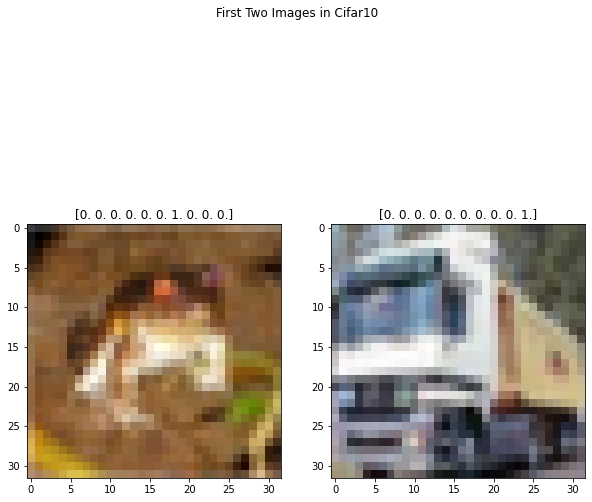

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,10))
for i in range(2):
    axes[i].imshow(X_train_img[i])
    axes[i].set_title(y_train_img[i])
    
fig.suptitle('First Two Images in Cifar10')
plt.show()

# Adding Pretrained Layers


## VGG1

[VGG16](https://neurohive.io/en/popular-networks/vgg16/) is a very deep image classification model architecture.  

It starts with a set input shape, (224,224, 3).  This represents a 2 dimensional RGB image (first two dimensions) and 3 color channels (last dimension).

It uses convolutional and max pooling layers, but don't worry about what these are yet.  We will learn more about these soon.

We will be setting the weights of this model to a collection of pre-trained weights called 'imagenet'.  These weights are the result of the VGG16 model's training on the [imagenet dataset](https://en.wikipedia.org/wiki/ImageNet).  This is a database of 14 million images in 20,000 different categories.  

VGG19: https://keras.io/api/applications/vgg/#vgg19-function

In [42]:
#Load the VGG16 model
from keras.applications import VGG16
pretrained = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=image_size)

pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [43]:
cnn_transfer = Sequential()
cnn_transfer.add(pretrained)

# freezing layers so they don't get retrained with your new data
for layer in cnn_transfer.layers:
    layer.trainable=False 

In [44]:
# adding our own dense layers
cnn_transfer.add(layers.Flatten())
cnn_transfer.add(layers.Dense(132, activation='relu'))
cnn_transfer.add(layers.Dense(10, activation='softmax'))

In [45]:
# to verify that the weights are "frozen" 
for layer in cnn_transfer.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten True
dense True
dense_1 True


In [46]:
cnn_transfer.compile(loss='categorical_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
cnn_transfer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 132)               67716     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1330      
Total params: 14,783,734
Trainable params: 69,046
Non-trainable params: 14,714,688
_________________________________________________________________


## Create a custom image classification model.

In [47]:
cnn_custom = Sequential()
cnn_custom.add(layers.Input(shape=image_size))
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.MaxPool2D())
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.MaxPool2D())
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.MaxPool2D())
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
cnn_custom.add(layers.Flatten())
cnn_custom.add(Dense(132, activation='relu'))
cnn_custom.add(Dense(10, activation='softmax'))

cnn_custom.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_custom.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        16448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)         

## Let's test each:

Notice that the custom model is much shallower than VGG16, but has more trainable weights.  Take note of accuracy and training time between the two models.

Transfer learning is not always the most successful tactic, but it tends to reduct training time and is sometimes more successful.  It is one more tool for the toolkit!

In [48]:
%%time
#fit and evaluate the custom CNN.
cnn_custom.fit(X_train_img, y_train_img,
               epochs=1,
               batch_size=1024,
               validation_split=.2)
custom_loss, custom_accuracy = cnn_custom.evaluate(X_test_img, y_test_img)

print(f'Loss of custom model on test set: {custom_loss:.2f}')
print(f'Accuracy of custom model on test set: {custom_accuracy: .2f}')

313/313 [==============================] - 6s 20ms/step - loss: 1.9713 - accuracy: 0.2650
Loss of custom model on test set: 1.97
Accuracy of custom model on test set:  0.26
CPU times: user 9min 22s, sys: 2min 18s, total: 11min 40s
Wall time: 1min 44s


In [49]:
%%time
#fit and evaluate the CNN using transfer learning.
cnn_transfer.fit(X_train_img, y_train_img,
                 epochs=1,
                 batch_size=1024,
                 validation_split=.2)
transfer_loss, transfer_accuracy = cnn_transfer.evaluate(X_test_img, y_test_img)
print(f'Loss of transfer model on test set: {transfer_loss:.2f}')
print(f'Accuracy of transfer model on test set: {transfer_accuracy: .2f}')

313/313 [==============================] - 51s 164ms/step - loss: 3.7566 - accuracy: 0.4335
Loss of transfer model on test set: 3.76
Accuracy of transfer model on test set:  0.43
CPU times: user 25min 30s, sys: 2min 12s, total: 27min 43s
Wall time: 3min 46s


# Conclusion

In this notebook you:

1. Used Talos to search for optimal hyperparameters for a multi-layered perceptron with dense and dropout layers.
2. Saved the tuned model and reloaded it using saved weights.
3. Used transfer learning to reduce the training time for an image classification model.